In [1]:
!pip install micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import random

In [3]:
class Value:

  def __init__(self,data, _children=(), _op='', label=''):
    self.data=data
    self.grad=0.0
    self._backward = lambda: None
    self._prev=set(_children)
    self._op=_op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data + other.data,(self,other),'+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self*(-1)

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data*other.data,(self,other),'*')

    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self*other

  def __truediv__(self, other):
    return self*(other**(-1))

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supports int and float for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other*(self.data **(other-1))*out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ) , 'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad

    out._backward=_backward
    return out

  def exp(self):
    x =  self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad+= out.data*out.grad
    out._backward = _backward
    return out


  def backward(self):
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [4]:
def trace(root):
  #set of all nodes and edges
  nodes,edges =set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format='svg', graph_attr={'rankdir':'LR'})

  nodes,edges=trace(root)
  for n in nodes:
    uid=str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name=uid+n._op, label=n._op)
      dot.edge(uid+n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2))+n2._op)

  return dot

In [5]:
def lol():
  h=0.001
  a=Value(2.0, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L= d*f;L.label='L'
  L1=L.data

  a=Value(2.0, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L= d*f;L.label='L'
  L2=L.data+h

  print((L2-L1)/h)

lol()

1.000000000000334


In [6]:
# inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2';
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1w1 + x2w2'
n=x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

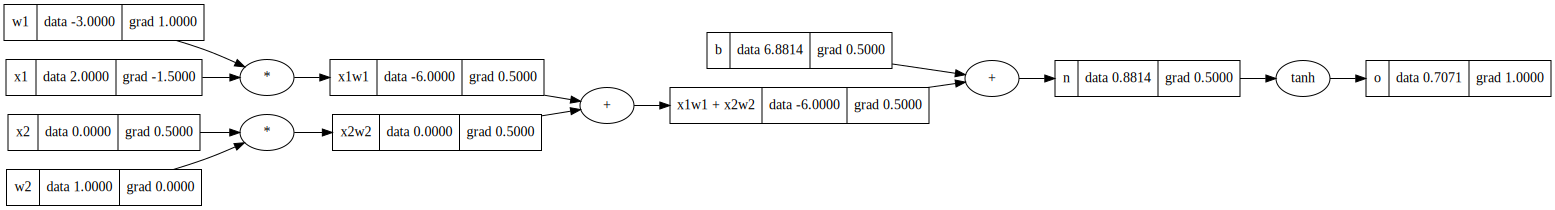

In [7]:
draw_dot(o)

In [8]:
# inputs
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1w1 + x2w2'
n=x1w1x2w2+b; n.label='n'

# ---
e=(2*n).exp()
o = (e-1)/(e+1)
# ---
o.label='o'
o.backward()

#### Same thing but in pytorch

In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double()                  ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ;w2.requires_grad = True
b =  torch.Tensor([6.8813735870195432]).double()   ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

#### Neurons

In [16]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))


  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
    out = act.tanh()
    return out


class Layer:

  def __init__(self, nin, nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) ==1 else outs

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.9061652283314364)

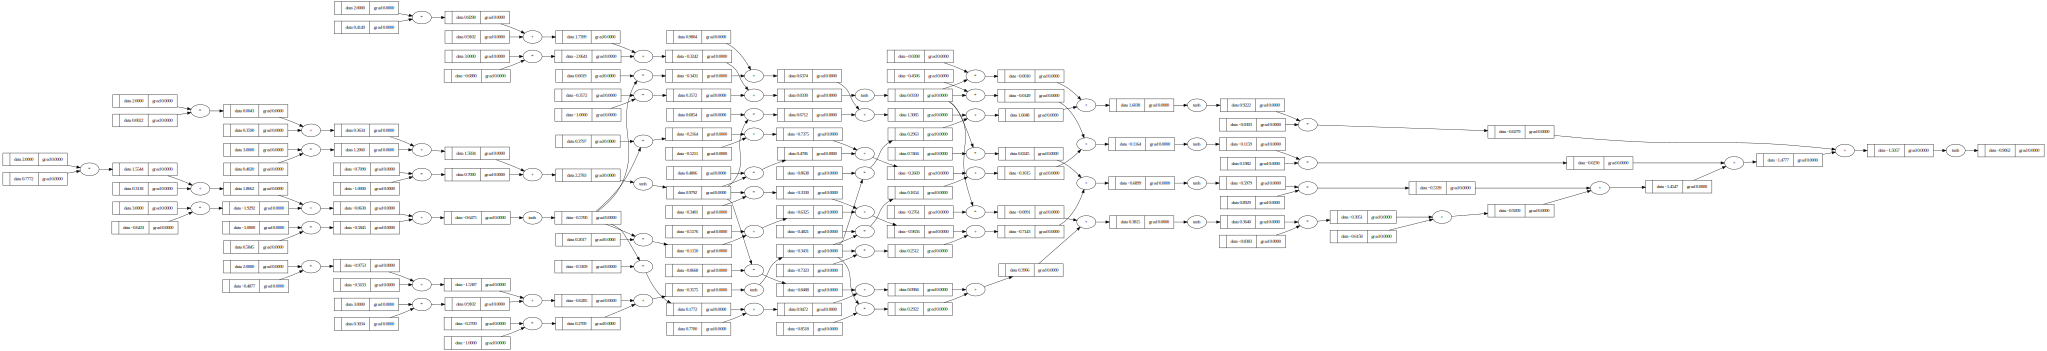

In [19]:
draw_dot(n(x))